## 9. WAV 파일 노이즈 분석(주파수 대역 에너지 분석)


📈 클래스별 주파수 대역 에너지 통계:
                                           low_freq_energy             \
                                                     count       mean   
class_label                                                             
1.Car/1.horn_of_car                                 3588.0 -39.143452   
1.Car/2.siren_of_car                                2239.0 -44.264431   
1.Car/3.driving_sound_of_car                        1909.0 -26.432106   
2.Motorcycle/4.horn_of_motorcycle                   5079.0 -36.420666   
2.Motorcycle/5.driving_sound_of_motorcycle          5233.0 -26.619488   

                                                                            \
                                                 std        min        25%   
class_label                                                                  
1.Car/1.horn_of_car                         7.328981 -58.852341 -43.910934   
1.Car/2.siren_of_car                        9.650121 -70.075806 -50.990892   
1.

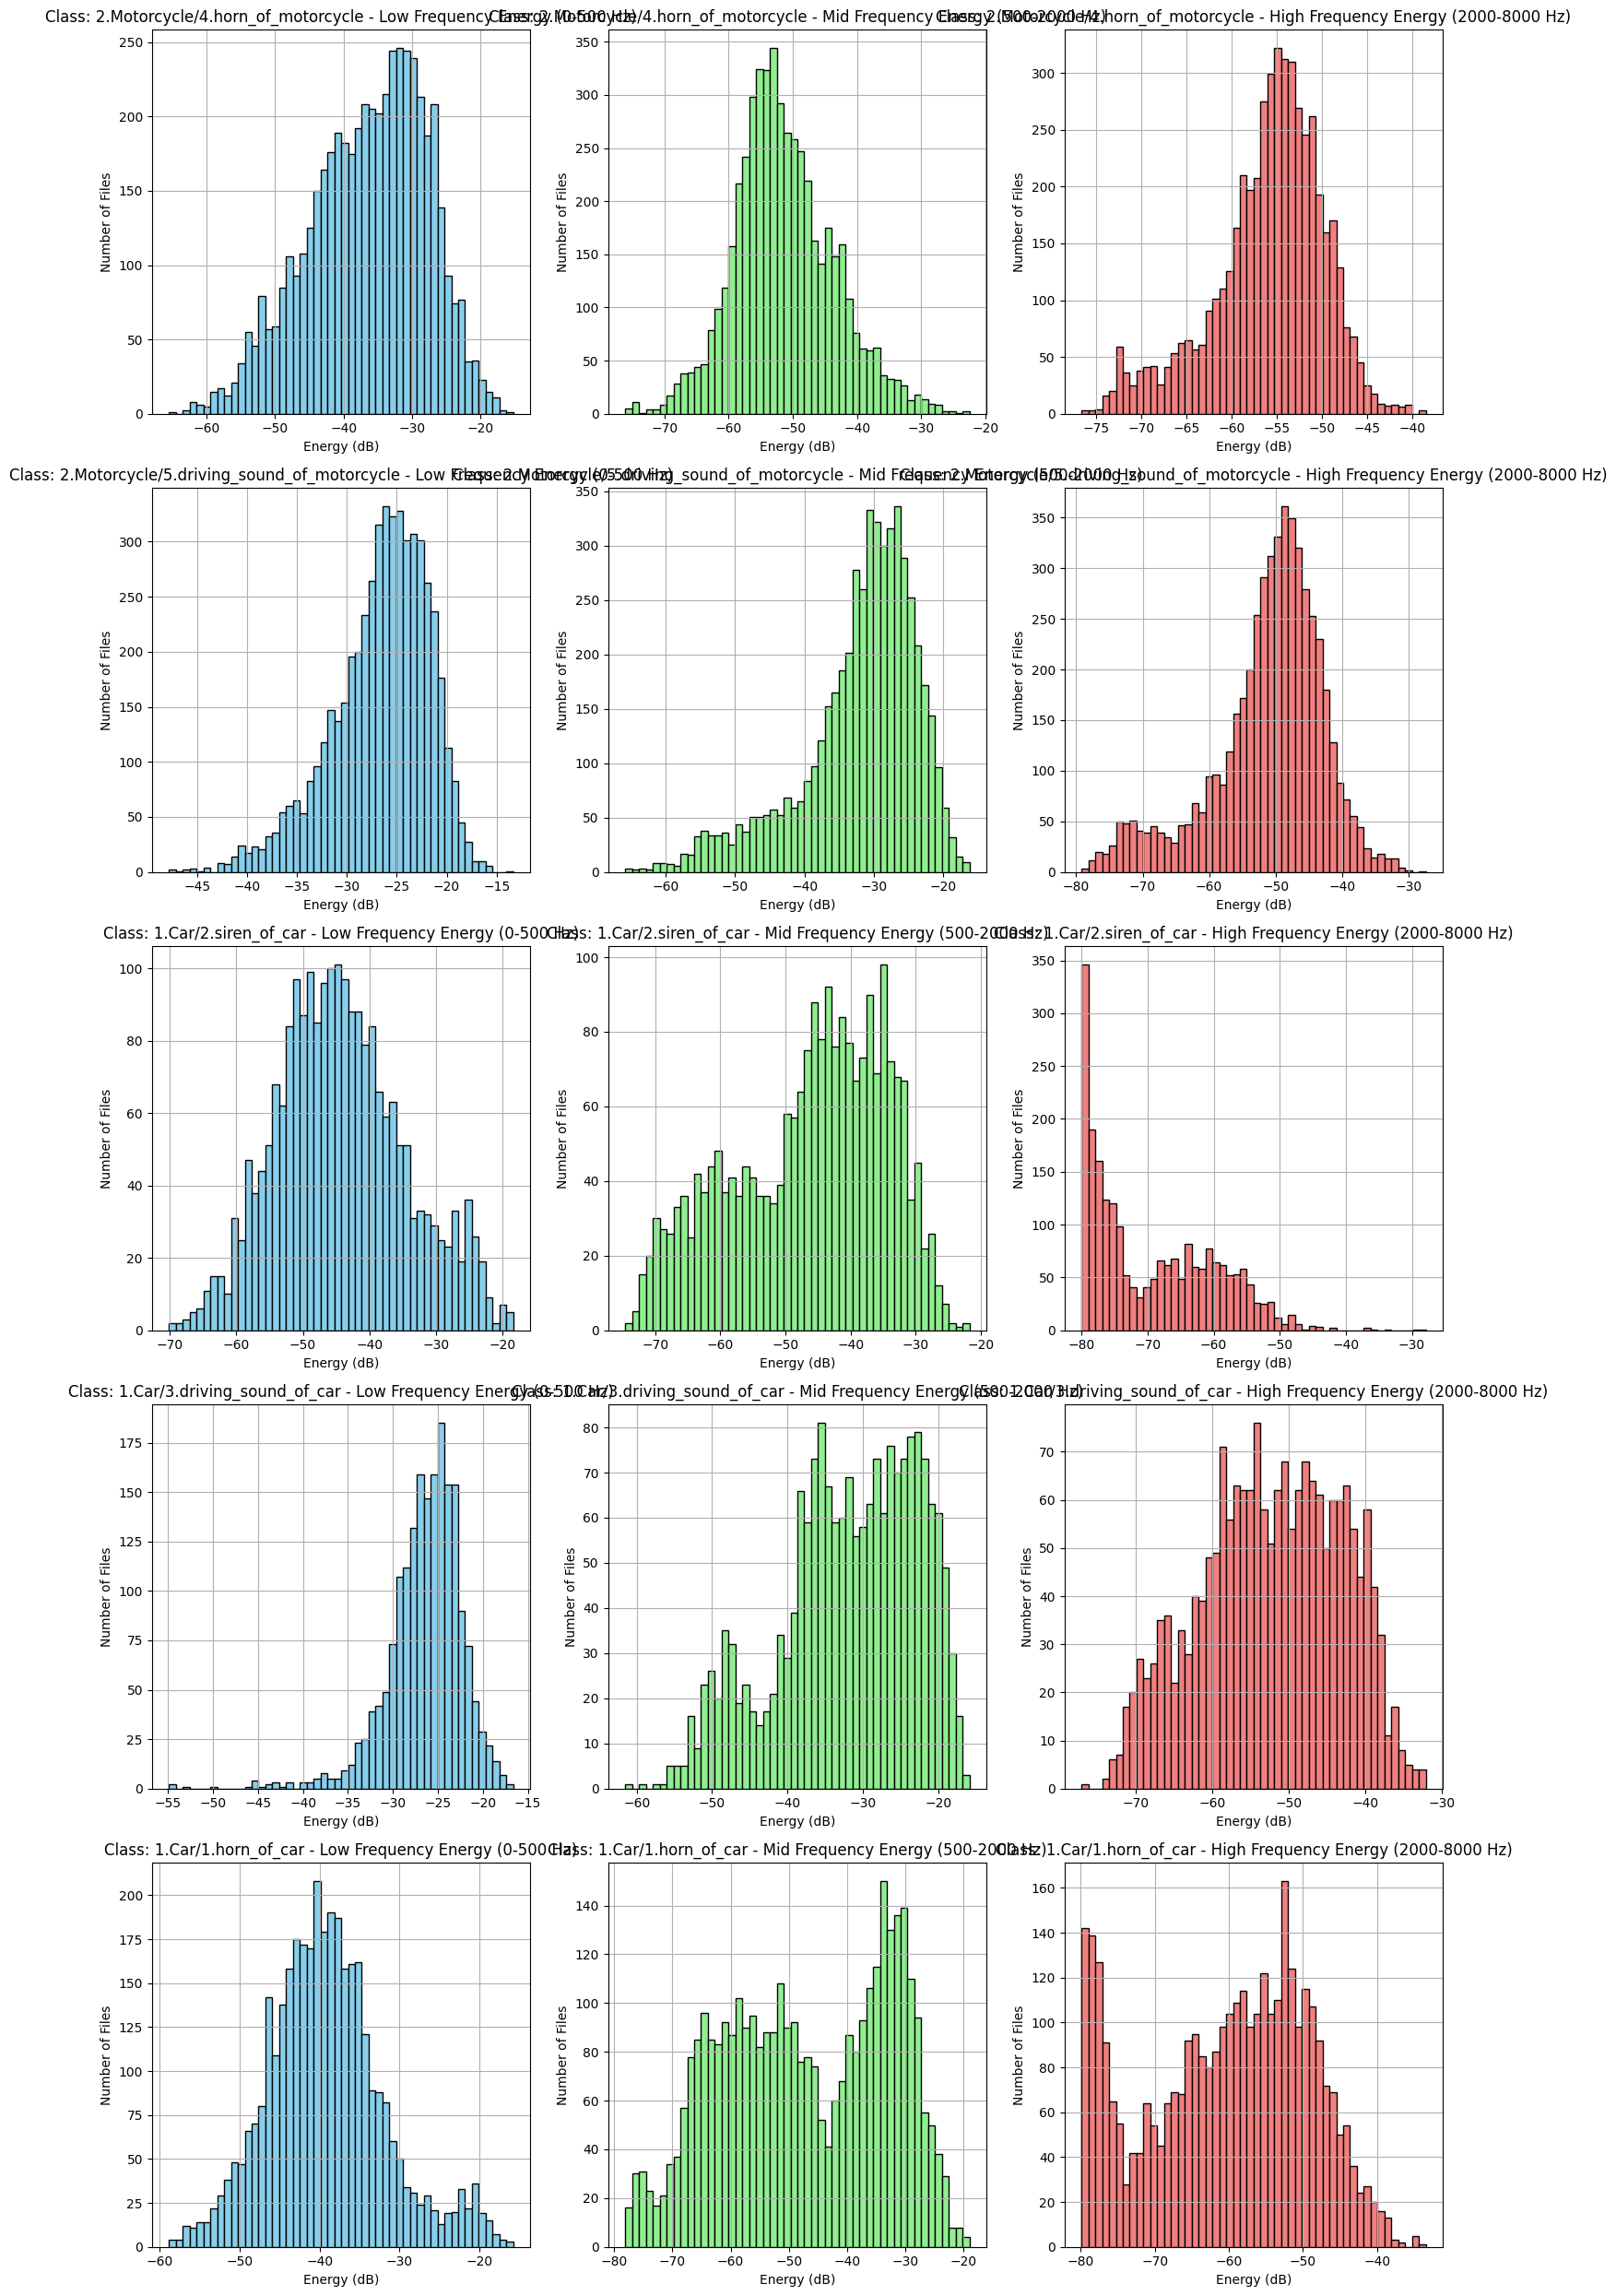


과도한 배경 소음이 있는 파일 수: 0

과도한 배경 소음이 있는 파일 목록 (최대 10개):


In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 분석할 WAV 파일이 위치한 상위 디렉토리
data_dir = "/home/ubuntu/data"

# 파일 정보를 저장할 리스트
file_info_list = []

# 검사할 파일 확장자
audio_extensions = [".wav"]

# 분석할 주파수 대역 설정 (예시: 0~500 Hz)
low_freq_band = (0, 500)
mid_freq_band = (500, 2000)
high_freq_band = (2000, 8000)

# 주파수 대역에서 에너지 비율 임계값 설정 (과도한 배경 소음 판단 기준)
noise_threshold = 0.1  # 조정 가능

# WAV 파일 검사
for root, _, files in os.walk(data_dir):
    for file in files:
        if any(file.endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(root, file)
            try:
                # librosa로 파일 로드하여 오디오 데이터 및 샘플링 레이트 획득
                y, sr = librosa.load(file_path, sr=None, mono=True)
                
                # 주파수 스펙트럼 계산
                S = np.abs(librosa.stft(y))
                S_db = librosa.amplitude_to_db(S, ref=np.max)
                
                # 주파수 대역별 에너지 계산
                freqs = librosa.fft_frequencies(sr=sr)
                low_freq_energy = np.mean(S_db[(freqs >= low_freq_band[0]) & (freqs < low_freq_band[1])])
                mid_freq_energy = np.mean(S_db[(freqs >= mid_freq_band[0]) & (freqs < mid_freq_band[1])])
                high_freq_energy = np.mean(S_db[(freqs >= high_freq_band[0]) & (freqs < high_freq_band[1])])
                
                # 클래스 정보 추출 (예시로, 상위 2개의 폴더 이름을 사용)
                path_parts = os.path.normpath(file_path).split(os.sep)
                class_label = os.path.join(path_parts[-3], path_parts[-2])  # 예: '2.Motorcycle/4.horn_of_motorcycle'

                # 파일 정보 저장
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "low_freq_energy": low_freq_energy,
                    "mid_freq_energy": mid_freq_energy,
                    "high_freq_energy": high_freq_energy,
                    "class_label": class_label
                })

            except Exception as e:
                # 파일 로드 중 오류 발생 시 None으로 설정
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "low_freq_energy": None,
                    "mid_freq_energy": None,
                    "high_freq_energy": None,
                    "class_label": None,
                    "error_msg": str(e)
                })

# 데이터프레임으로 변환
df = pd.DataFrame(file_info_list)

# 오류가 없는 파일만 선택
df_valid = df[df["low_freq_energy"].notnull() & df["mid_freq_energy"].notnull() & df["high_freq_energy"].notnull()]

# 클래스별 주파수 대역 에너지 통계 계산
class_freq_stats = df_valid.groupby("class_label")[["low_freq_energy", "mid_freq_energy", "high_freq_energy"]].describe()
print("\n📈 클래스별 주파수 대역 에너지 통계:")
print(class_freq_stats)

# 클래스별 주파수 대역 에너지 분포 시각화
unique_classes = df_valid["class_label"].unique()
num_classes = len(unique_classes)

# 그래프 크기 설정
fig, axes = plt.subplots(nrows=num_classes, ncols=3, figsize=(15, 5*num_classes))

if num_classes == 1:
    axes = [axes]  # 클래스가 하나인 경우에도 리스트로 만들기

for i, class_label in enumerate(unique_classes):
    class_data = df_valid[df_valid["class_label"] == class_label]
    
    axes[i][0].hist(class_data["low_freq_energy"], bins=50, color='skyblue', edgecolor='black')
    axes[i][0].set_title(f'Class: {class_label} - Low Frequency Energy (0-500 Hz)')
    axes[i][0].set_xlabel('Energy (dB)')
    axes[i][0].set_ylabel('Number of Files')
    axes[i][0].grid(True)

    axes[i][1].hist(class_data["mid_freq_energy"], bins=50, color='lightgreen', edgecolor='black')
    axes[i][1].set_title(f'Class: {class_label} - Mid Frequency Energy (500-2000 Hz)')
    axes[i][1].set_xlabel('Energy (dB)')
    axes[i][1].set_ylabel('Number of Files')
    axes[i][1].grid(True)

    axes[i][2].hist(class_data["high_freq_energy"], bins=50, color='lightcoral', edgecolor='black')
    axes[i][2].set_title(f'Class: {class_label} - High Frequency Energy (2000-8000 Hz)')
    axes[i][2].set_xlabel('Energy (dB)')
    axes[i][2].set_ylabel('Number of Files')
    axes[i][2].grid(True)

plt.tight_layout()
plt.show()

# 과도한 배경 소음이 있는 파일 목록 출력 (최대 10개)
noisy_files = df_valid[df_valid["low_freq_energy"] > noise_threshold]

print(f"\n과도한 배경 소음이 있는 파일 수: {len(noisy_files)}")
print("\n과도한 배경 소음이 있는 파일 목록 (최대 10개):")
for idx, row in noisy_files.head(10).iterrows():
    print(f"파일: {row['file_name']}, Low Frequency Energy: {row['low_freq_energy']:.2f} dB, 경로: {row['file_path']}")


### 📊 (참고) 클래스별 주파수 대역 에너지 통계 해석
1. Low Frequency Energy (저주파 에너지: 0-500 Hz)
- Count: 해당 클래스의 파일 개수입니다.
- Mean: 평균 저주파 에너지 수준입니다.
- Std: 표준 편차로, 값이 클수록 저주파 에너지 수준의 변동이 큽니다.
- Min: 최소 저주파 에너지 값입니다.
- 25%: 저주파 에너지 값의 하위 25% 지점입니다.
- 50% (Median): 저주파 에너지 값의 중위수입니다.
- 75%: 저주파 에너지 값의 상위 25% 지점입니다.
- Max: 최대 저주파 에너지 값입니다.

2. Mid Frequency Energy (중주파 에너지: 500-2000 Hz)
- Count: 해당 클래스의 파일 개수입니다.
- Mean: 평균 중주파 에너지 수준입니다.
- Std: 표준 편차로, 값이 클수록 중주파 에너지 수준의 변동이 큽니다.
- Min: 최소 중주파 에너지 값입니다.
- 25%: 중주파 에너지 값의 하위 25% 지점입니다.
- 50% (Median): 중주파 에너지 값의 중위수입니다.
- 75%: 중주파 에너지 값의 상위 25% 지점입니다.
- Max: 최대 중주파 에너지 값입니다.

3. High Frequency Energy (고주파 에너지: 2000-8000 Hz)
- Count: 해당 클래스의 파일 개수입니다.
- Mean: 평균 고주파 에너지 수준입니다.
- Std: 표준 편차로, 값이 클수록 고주파 에너지 수준의 변동이 큽니다.
- Min: 최소 고주파 에너지 값입니다.
- 25%: 고주파 에너지 값의 하위 25% 지점입니다.
- 50% (Median): 고주파 에너지 값의 중위수입니다.
- 75%: 고주파 에너지 값의 상위 25% 지점입니다.
- Max: 최대 고주파 에너지 값입니다.

> 결과 해석 방법
- 평균값 (Mean): 각 클래스의 주파수 대역 에너지 수준을 파악할 수 있습니다.  
예: 1.Car/1.horn_of_car 클래스의 저주파 평균 에너지는 -39.14 dB입니다.  
- 표준 편차 (Std): 주파수 대역 에너지 수준의 변동성을 나타냅니다.  
값이 크면 주파수 대역 에너지가 크게 변동한다는 의미입니다.  
값이 작으면 주파수 대역 에너지가 고르게 분포된다는 의미입니다.  
최소값 및 최대값 (Min, Max): 각 클래스의 주파수 대역 에너지 범위를 파악할 수 있습니다.  
예: 1.Car/1.horn_of_car 클래스의 고주파 에너지 범위는 -79.90 dB에서 -33.43 dB입니다.  
- 분위수 (25%, 50%, 75%): 데이터 분포의 주요 지점을 나타냅니다.  
중위수(50%)는 중앙값으로, 데이터의 중심 위치를 파악할 수 있습니다.  
- 과도한 배경 소음 판단 기준  
Noise Threshold (배경 소음 임계값): 특정 주파수 대역의 에너지가 임계값을 초과하면 과도한 배경 소음이 있는 것으로 판단합니다.  
예: 저주파 에너지가 -15 dB 이상인 경우 과도한 배경 소음이 있는 것으로 간주할 수 있습니다.  

> **주파수**  
- 주파수는 소리의 높낮이를 나타내는 개념입니다. 주파수는 1초에 몇 번의 진동이 발생하는지를 나타내며, 단위는 헤르츠(Hz)입니다.  
```
```

> 주파수 대역
- 주파수 대역은 다양한 주파수 범위에 따라 나눌 수 있습니다. 인간의 귀는 일반적으로 20Hz에서 20,000Hz(20kHz)까지의 주파수를 들을 수 있습니다. 아래는 주파수 대역의 일반적인 분류입니다.

* 저주파 대역 (Low Frequency)  
범위: 20Hz ~ 500Hz  
특징: 낮은 소리, 베이스나 드럼 같은 깊고 무거운 소리  
예시: 둥둥거리는 소리, 엔진 소리  

* 중주파 대역 (Mid Frequency)  
범위: 500Hz ~ 2000Hz  
특징: 대부분의 음악과 목소리가 포함되는 중간 주파수  
예시: 사람의 음성, 악기 소리  

* 고주파 대역 (High Frequency)  
범위: 2000Hz ~ 20,000Hz  
특징: 높은 소리, 밝고 샤프한 소리  
예시: 새소리, 비명 소리, 트라이앵글 소리  